In [1]:
#Thư viện để xử lý dữ liệu
import pandas as pd
import numpy as np

#Thư viện để thống kê dữ liệu
from collections import Counter

#Thư viện để token hóa dữ liệu chữ
import spacy

#Thư viện để xử lý các vấn đề của học máy và xây dựng mô hình
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional

#Thư viện để trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện lưu và tải mô hình
import pickle

# Thư viện tạo ra app_desktop
import tkinter as tk
from tkinter import messagebox

from tqdm import keras

In [2]:
#Load data
data = pd.read_csv('../jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')

In [3]:
df = pd.DataFrame(data)

In [62]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [63]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [64]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
target_columns = list(np.array(df.columns)[2:])

In [66]:
# Thêm một số nhãn cho mục đích phân tích
df['non-toxic'] = 1 - df[target_columns].max(axis=1)
df['toxicity_type_defined'] = df[['insult','obscene','identity_hate','threat']].max(axis=1)
df['toxic_undefined'] = 0
df.loc[(df['toxicity_type_defined']==0)&(df['toxic']==1),'toxic_undefined'] = 1
df['soft_toxic'] = 0
df.loc[(df['toxicity_type_defined']==1)&(df['toxic']==0),'soft_toxic'] = 1
analysis_columns = target_columns + ['non-toxic', 'toxic_undefined', 'soft_toxic']

In [67]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic,toxicity_type_defined,toxic_undefined,soft_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0,0,0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\1817551988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set3')  # Set3 is an example of a color palette


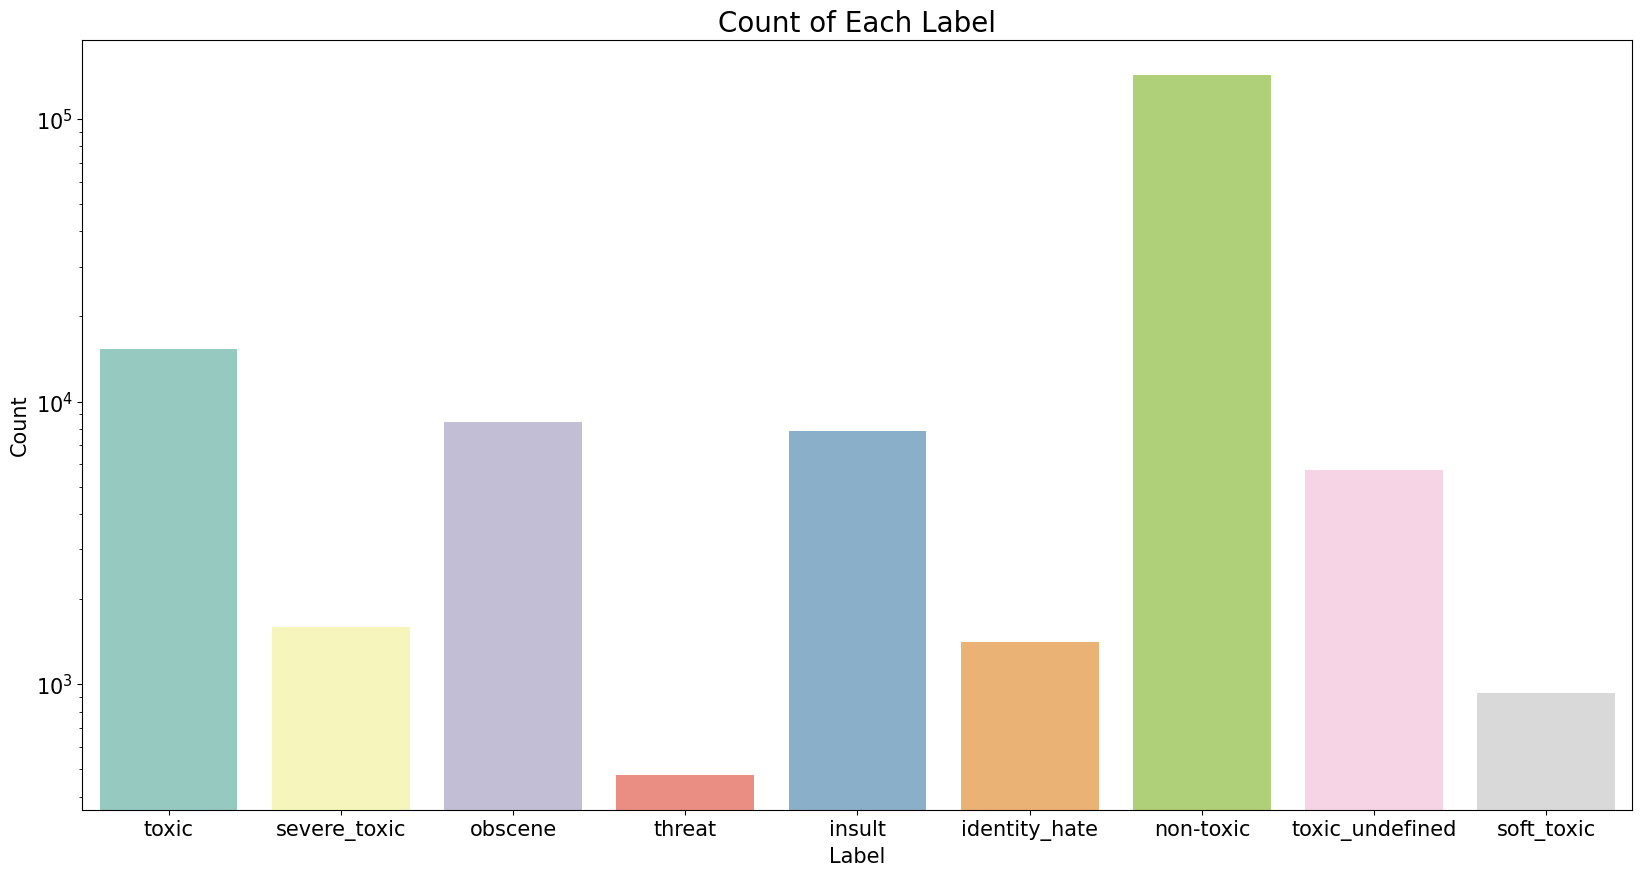

In [68]:
# Trực quan hóa dữ liệu đã được phân tích
label_counts = df[analysis_columns].sum()

plt.figure(figsize=(20, 10))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set3')  # Set3 is an example of a color palette
ax.set_yscale("log")
ax.tick_params(labelsize=15)
plt.xlabel('Label', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Count of Each Label', fontsize=20)
plt.show()

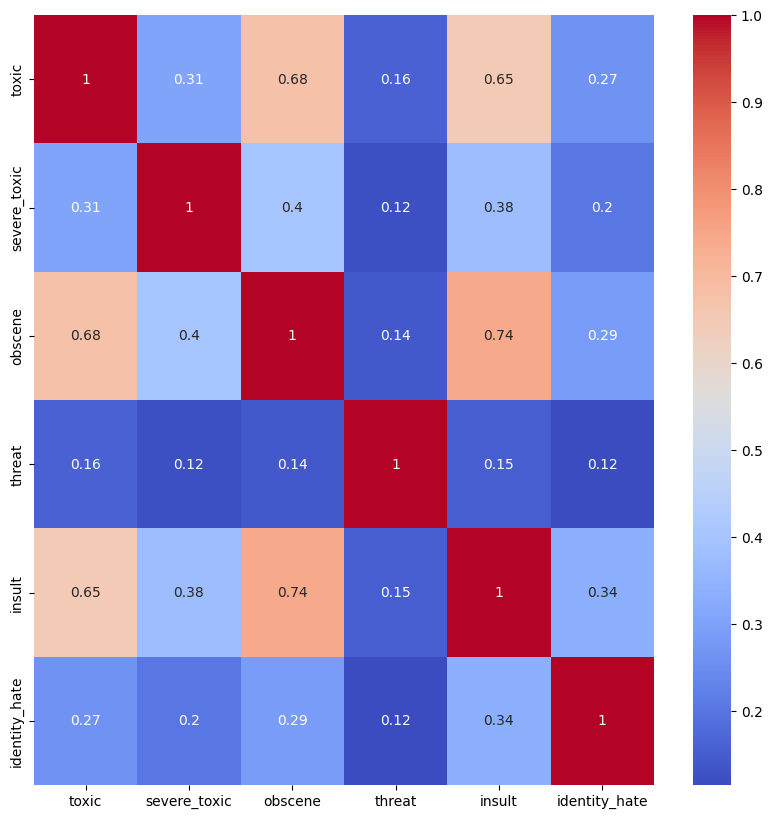

In [69]:
# Trực quan hóa các liên kết giữa các labels
heatmap_data = df[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='coolwarm', annot=True)
ax.tick_params(labelsize=10)

In [70]:
#Load spacy pagekage english pipeline
nlp = spacy.load('en_core_web_lg')

In [71]:
# Lấy các token không có stop word bên trong
nonstop_tokens = []
for doc in nlp.pipe(df['comment_text'].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        nonstop_tokens.append([t.lower_ for t in doc if t.is_alpha and not t.is_stop])
    else:
        nonstop_tokens.append(None)
df['nonstop_tokens'] = nonstop_tokens

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\3266969282.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=words, y=counts, palette='Set3')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\3266969282.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\3266969282.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=words, y=counts, palette='Set3')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\3266969282.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ti

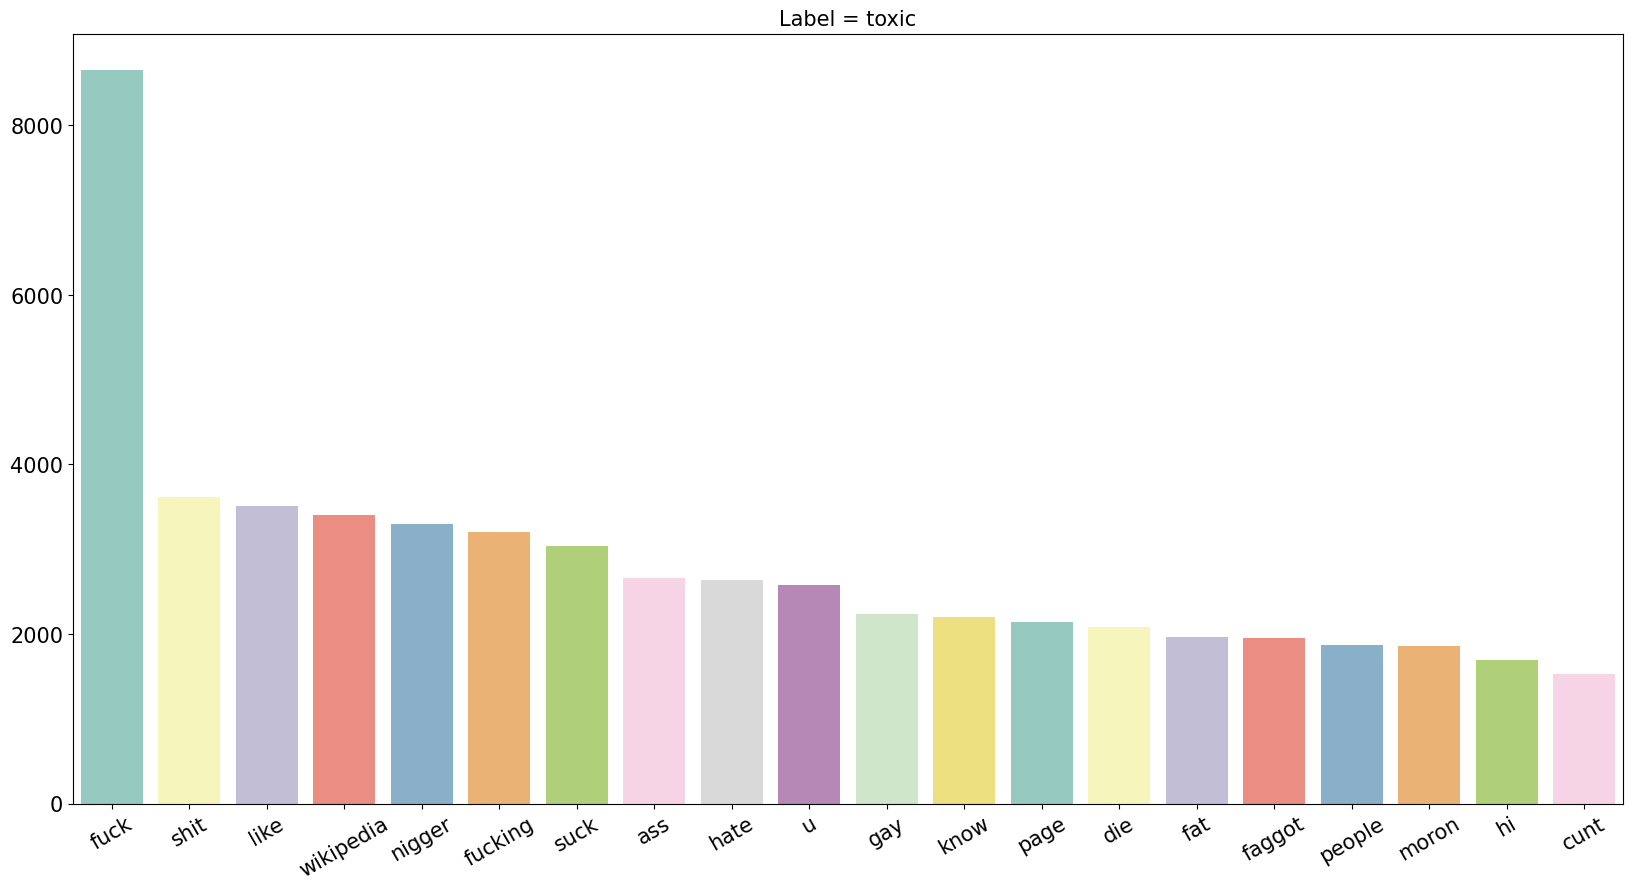

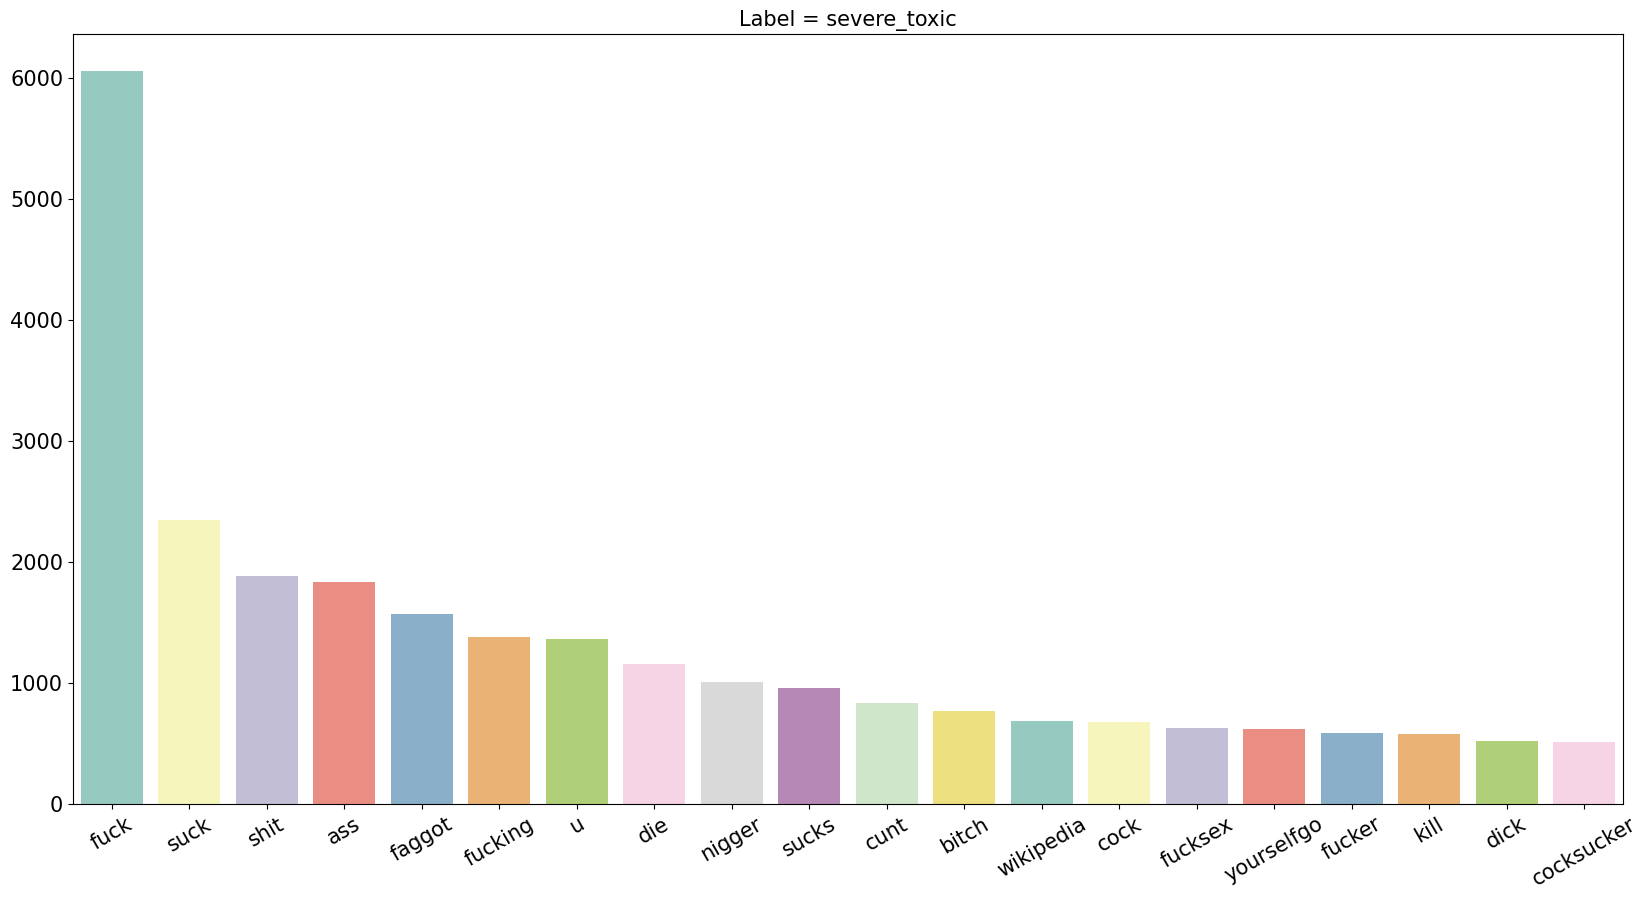

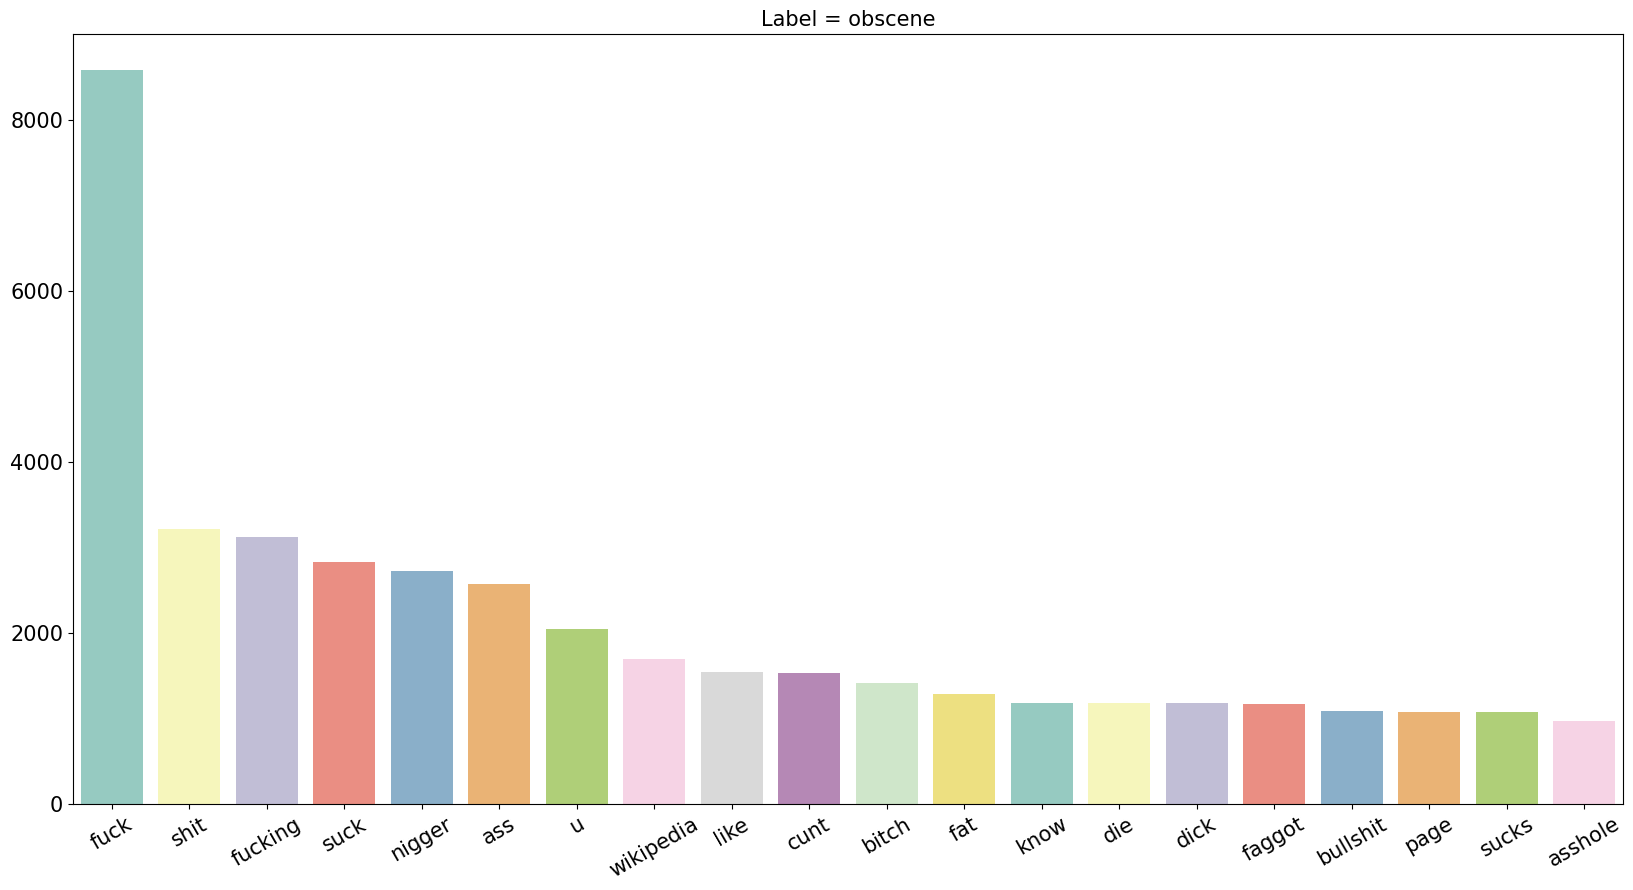

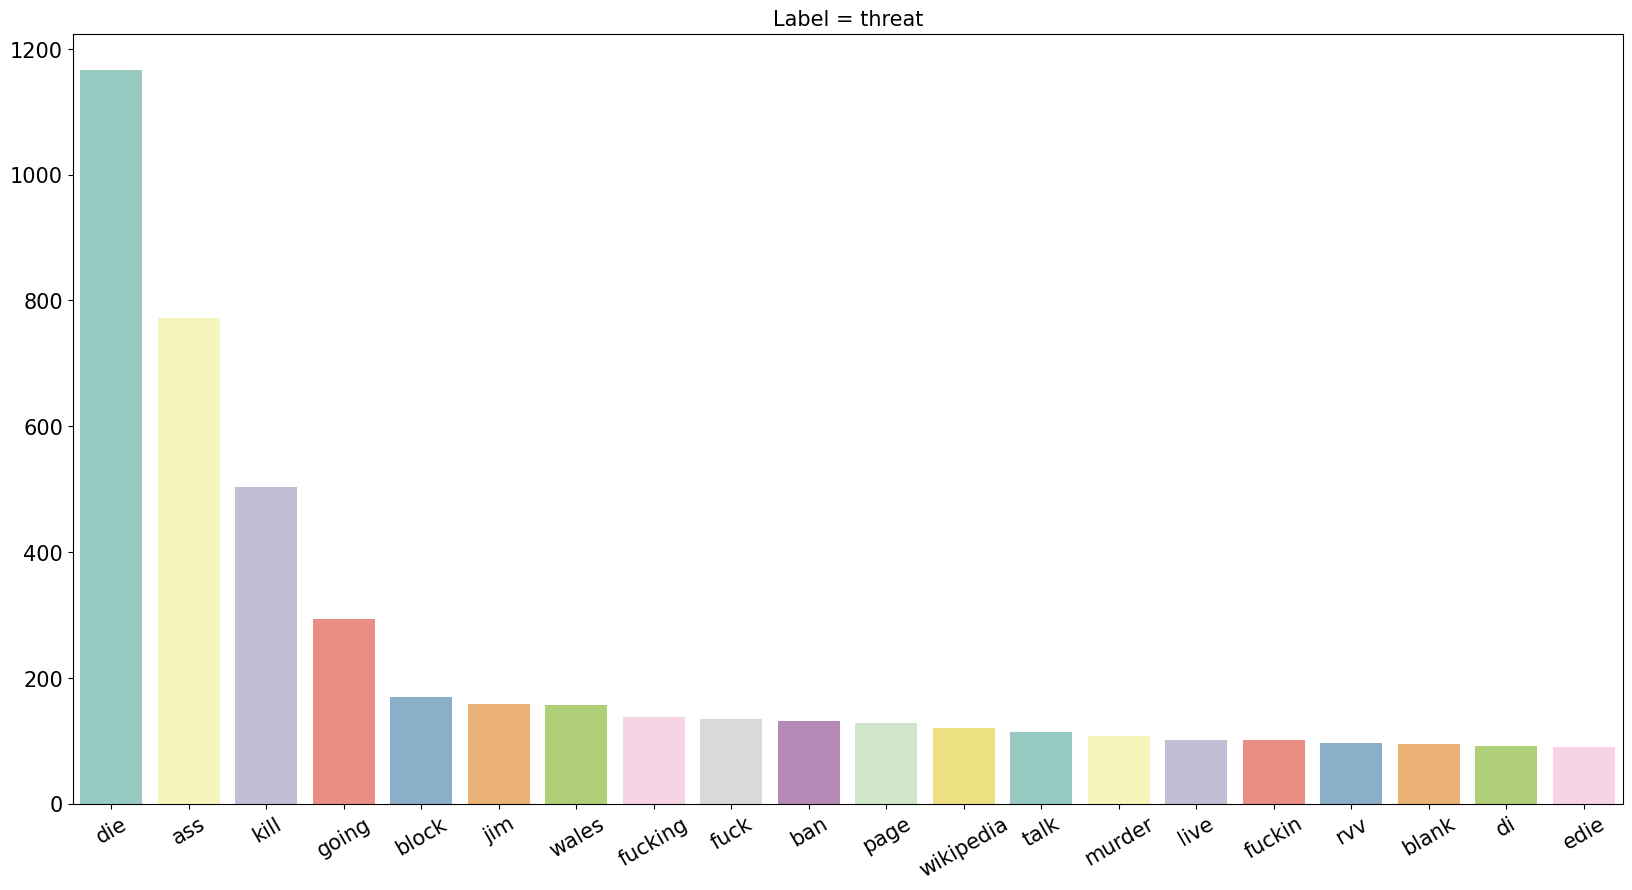

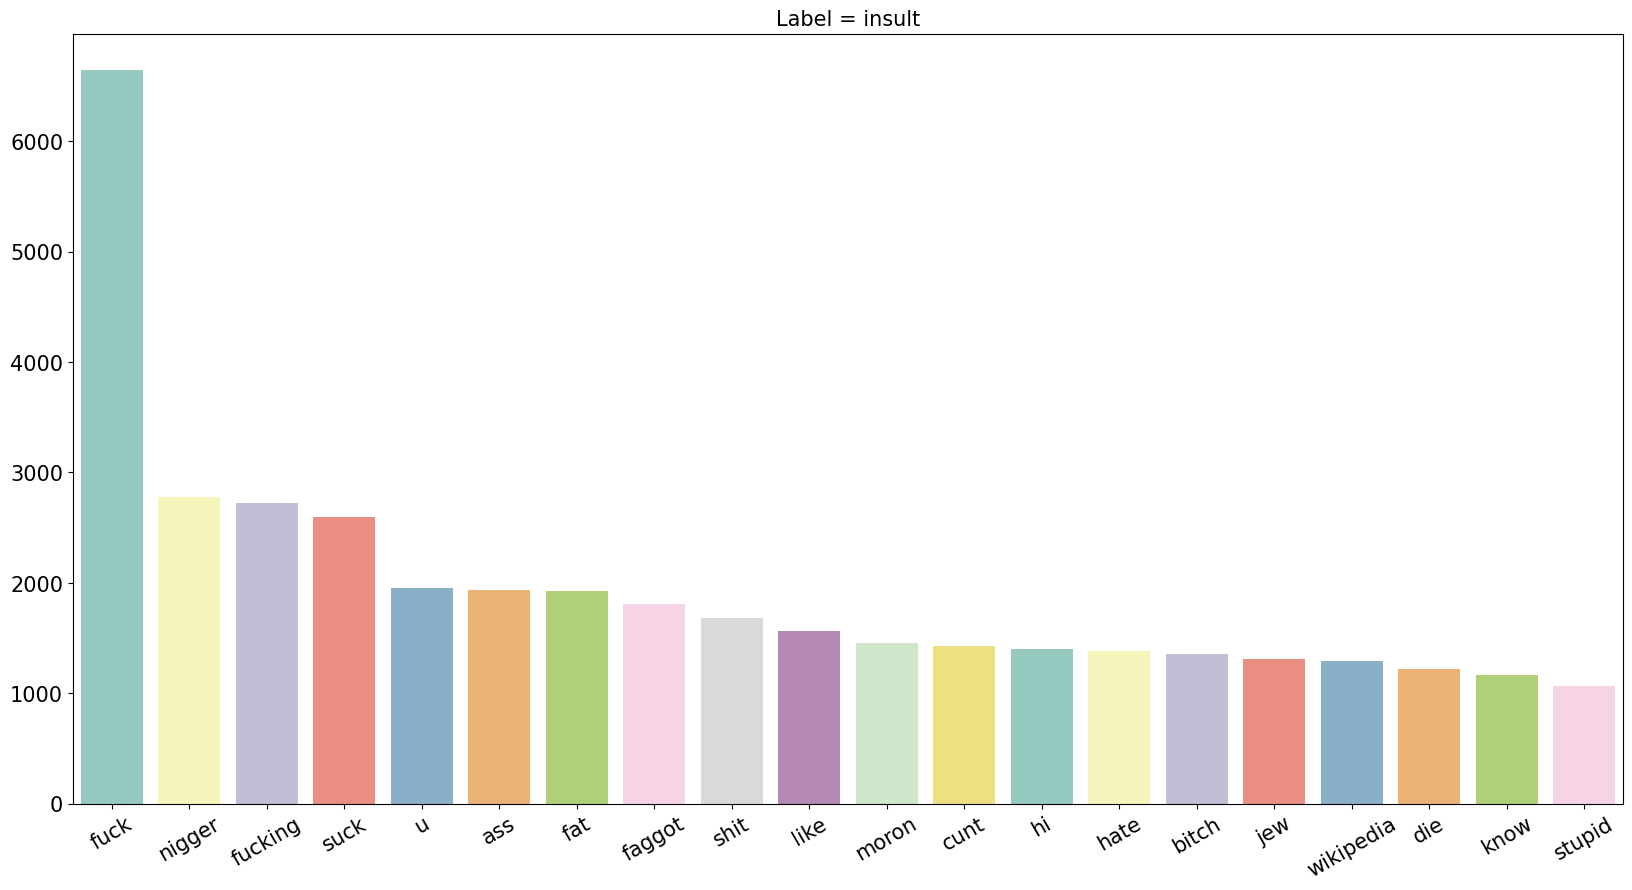

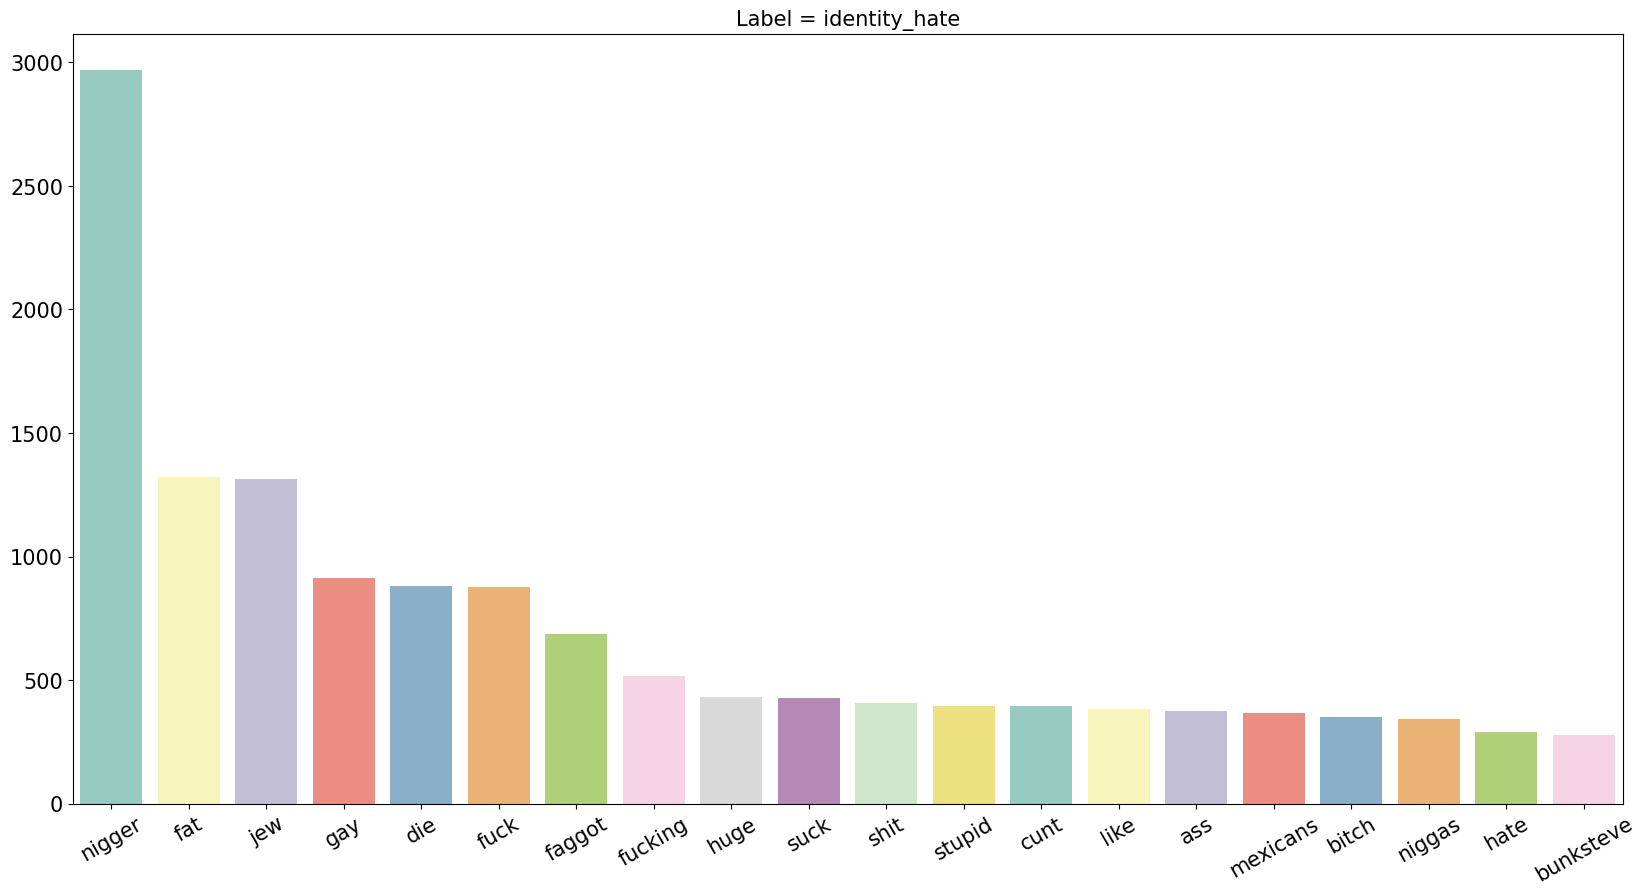

In [72]:
# Trực quan hóa những từ thường gặp trong các bình luận xúc phạm
for label in target_columns:
    word_list = list(df.loc[df[label]==1, 'nonstop_tokens'].explode())
    most_common = Counter(word_list).most_common(20)
    words = [w for w,_ in most_common]
    counts = [c for _,c in most_common]
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=words, y=counts, palette='Set3')
    ax.set_title(f'Label = {label}', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [5]:
X = df['comment_text']
y = df[target_columns].values

In [24]:
MAX_FEATURES = 20000 # số lượng từ trong vocal

# Vector hóa dữ liệu văn bản
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)

vectorized_text = vectorizer(X.values)

In [83]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)) # Tạo dữ liệu từ vectorized_text và y
dataset = dataset.cache() # Lưu trữ dữ liệu trên cache
dataset = dataset.shuffle(160000) # Xác trộn dữ liệu với khung là 160000
dataset = dataset.batch(16) # Tạo các batch cho dữ liệu
dataset = dataset.prefetch(8) # Cho phép dữ liệu được xử lý trước trong khi mô hình đang đào tạo.

In [84]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [85]:
# Xây dựng mô hình với Sequential
model = Sequential()
# Lớp Embedding với số lượng từ vựng tối đa là 20000 từ đã xác định + 1 là những từ chưa xác định
model.add(Embedding(MAX_FEATURES + 1, 32))
# # Lớp Bidirectional để huấn luyện hai lớp LSTM theo 2 hướng thuận và ngược
model.add(Bidirectional(LSTM(32, activation='tanh')))
# 3 lớp Dense được sử dụng để tạo ra các đặc trưng
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Lớp Dropout để tránh overfitting 
model.add(Dropout(0.5))
# Lớp cuối cùng có 6 nơ-ron tương ứng 6 cột taget_column với hàm kich hoạt  là sigmoid
model.add(Dense(6, activation='sigmoid'))

In [86]:
# Biên soạn mô hình
model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

In [87]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Huấn luyện mô hình
history = model.fit(train, epochs=5, batch_size=16, validation_data= val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1954s 280ms/step - Precision: 0.8213 - Recall: 0.6819 - accuracy: 0.9930 - loss: 0.0464 - val_Precision: 0.8090 - val_Recall: 0.7298 - val_accuracy: 0.9940 - val_loss: 0.0429
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1884s 270ms/step - Precision: 0.8336 - Recall: 0.6931 - accuracy: 0.9929 - loss: 0.0428 - val_Precision: 0.8880 - val_Recall: 0.6739 - val_accuracy: 0.9943 - val_loss: 0.0392
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1891s 271ms/step - Precision: 0.8404 - Recall: 0.7164 - accuracy: 0.9891 - loss: 0.0397 - val_Precision: 0.8705 - val_Recall: 0.7230 - val_accuracy: 0.9940 - val_loss: 0.0362
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1889s 270ms/step - Precision: 0.8434 - Recall: 0.7271 - accuracy: 0.9440 - loss: 0.0381 - val_Precision: 0.8506 - val_Recall: 0.7711 - val_accuracy: 0.9945 - val_loss: 0.0353
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1896s 272ms/step - Precision: 0.8495 - Recall: 0.7494 - accuracy: 0.9664 - loss: 0.0355 - val_P

<Figure size 2000x1000 with 0 Axes>

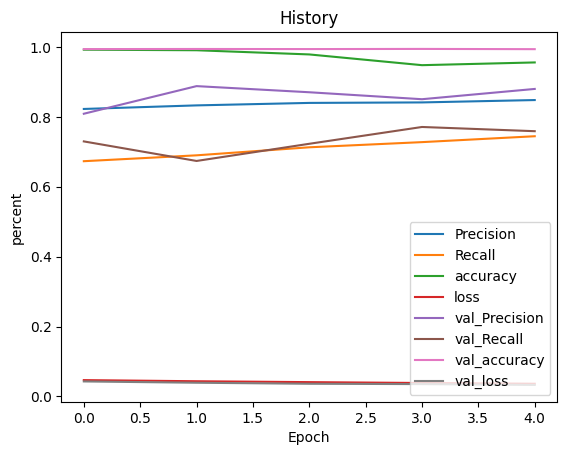

In [90]:
# Trực quan hóa số liêu mô hình sau khi huấn luyện
plt.figure(figsize=(20,10))
pd.DataFrame(history.history).plot()
plt.title('History')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.legend(loc='lower right')
plt.show()

In [91]:
# Tạo dữ đoán với câu mẫu
input_vectorized = vectorizer('You freaking suck! I am going to hit you.')
prediction = model.predict(np.expand_dims(input_vectorized, 0))
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
[[0.9998088  0.29687044 0.97804403 0.01997107 0.873213   0.14942525]]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\566515074.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_columns, y=y, palette="muted")


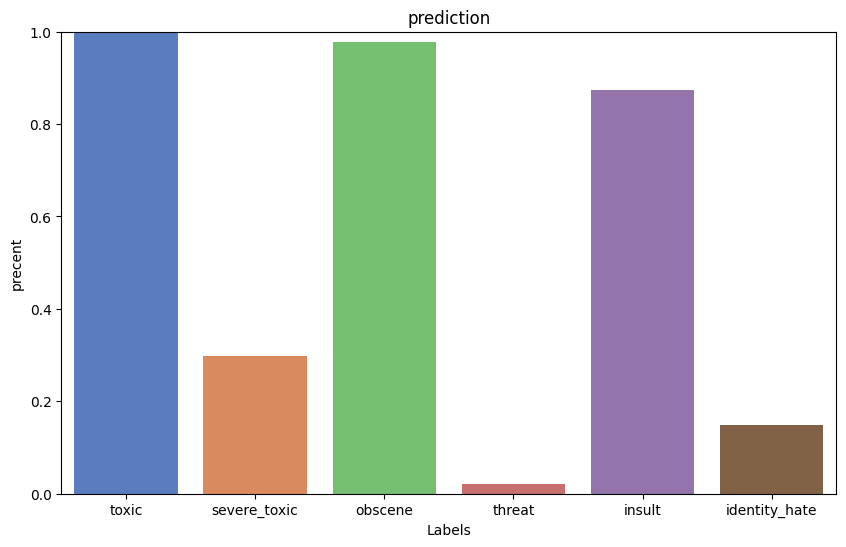

In [92]:
# Trực quan hóa kết quả dự đoán
y = prediction.reshape(6) # định hình lại dự đoán thành numpy_1_dim
# Tạo đồ thị
plt.figure(figsize=(10, 6))
sns.barplot(x=target_columns, y=y, palette="muted")
plt.title('prediction')
plt.ylabel('precent')
plt.xlabel('Labels')
plt.ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
plt.show()

In [93]:
# Tạo đánh giá dựa trên tập test
evalution = model.evaluate(test)

997/997 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - Precision: 0.8912 - Recall: 0.7724 - accuracy: 0.9939 - loss: 0.0314


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25140\1959069562.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=evalution, palette="viridis")


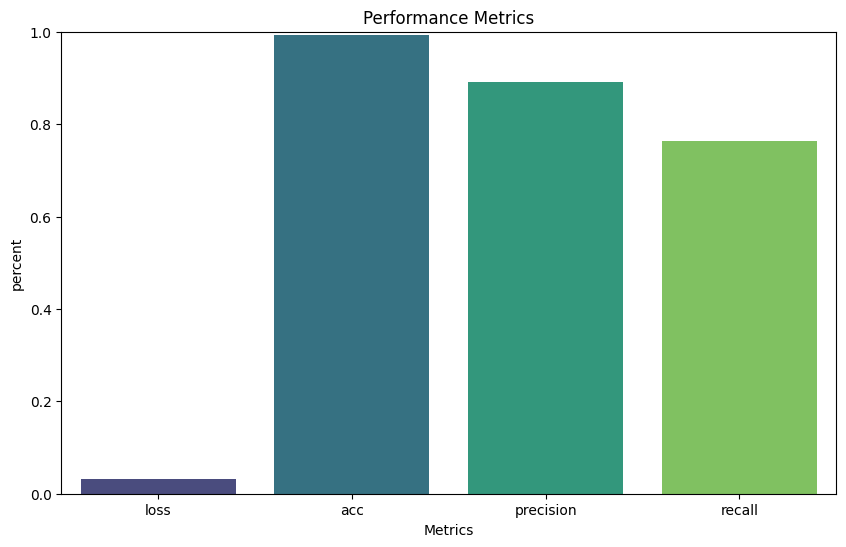

In [94]:
# Trực quan hóa đánh giá
metrics = ['loss', 'acc', 'precision', 'recall'] # các thông số đánh giá
# Tạo đồ thị
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=evalution, palette="viridis")
plt.title('Performance Metrics')
plt.ylabel('percent')
plt.xlabel('Metrics')
plt.ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
plt.show()